## Find best model

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [13]:
#data = pd.read_csv('../data/fullData_test.csv')
data = pd.read_csv('../data/fullData_test_toTransform.csv')
data.head()

,Код объекта,трассы,автомобильные мосты,Материал окон,Счетчик воды,гостевой паркинг,памятники архитектуры,культуры,пешеходные бульвары,Балкон,...,Стены,Адрес,Год постройки,Общая площадь,Высота потолков,Двор,Комнатность,подземный паркинг,Ремонт,цена
0,5757236,0,0,Пластиковые,есть,0,0,0,0,Есть балкон,...,Панельные,Древлянка,2017.0,30.60,2.50,открытый двор,1,0,Улучшенная черновая отделка,2390.0
1,5535905,0,0,Пластиковые,отсутствует,1,0,0,0,Нет балкона,...,Кирпичные,Голиковка,1979.0,18.00,2.55,открытый двор,1,0,Косметический ремонт,920.0
2,4644398,0,0,Пластиковые,есть,1,0,0,0,Есть балкон,...,Панельные,Древлянка,2021.0,57.83,2.70,закрытый двор,3,0,Улучшенная черновая отделка,3250.0
3,5667276,0,0,Пластиковые,есть,0,0,0,0,Лоджия,...,Монолитные,Ключевая,2016.0,41.20,2.70,открытый двор,2,0,Косметический ремонт,3590.0
4,4644417,0,0,Пластиковые,есть,1,0,0,0,Есть балкон,...,Панельные,Древлянка,2021.0,84.00,2.70,закрытый двор,4,0,Улучшенная черновая отделка,4500.0


In [14]:
X = data.drop(columns='цена')
Y = data['цена']

# data preprocessing

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import  OneHotEncoder

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
class YearsTransformer(BaseEstimator, TransformerMixin):
    """Apply binarization and ohetransform to 'Год постройки' column"""
    def __init__(self, bin_split=5):
        self.bin_split = bin_split
        self.is_fitted = False
        self.ohe = OneHotEncoder(sparse=False)

    def fit(self, X, Y=None):
        bins = np.linspace(X.min(), X.max(), self.bin_split)
        self.bins = bins
        year = pd.cut(X, bins=self.bins, include_lowest=True)
        self.ohe.fit(year.to_numpy().reshape(-1, 1))
        cols_name = self.ohe.get_feature_names_out()
        self.cols_name = [col.removeprefix('x0_') for col in cols_name]
        self.is_fitted = True
        return self

    def transform(self, X):
        assert self.is_fitted, 'call fit() method first, or use fit_transform()'
        year = pd.cut(X, bins=self.bins, include_lowest=True)
        year_ohe = self.ohe.transform(year.to_numpy().reshape(-1, 1))
        return pd.DataFrame(year_ohe, index=X.index, columns=self.cols_name)

    def inverse_transform(self, X):
        raise NotImplementedError()
    
    def fit_transform(self, X, Y=None):
        self.fit(X)
        return self.transform(X)
    
    def get_feature_names_out(self, input_features):
        return list(self.cols_name)

class Renovationtransformer(BaseEstimator, TransformerMixin):
    column_values = {'Черновая отделка' :0, 'Улучшенная черновая отделка' :1, 'Требует ремонта':2, 'Частичный ремонт':3,
                        'Косметический ремонт':4, 'Современный ремонт':5, 'Ремонт по дизайн проекту':6}
    def __init__(self):
        self.is_fitted = False

    def fit(self, X, Y=None):
        self.is_fitted = True
        return self

    def transform(self, X):
        assert self.is_fitted, 'call fit() method first, or use fit_transform()'
        X_labeled_renovation = X.replace(column_values)
        return X_labeled_renovation.to_frame()

    def inverse_transform(self, X):
        raise NotImplementedError()

    def fit_transform(self, X, Y=None):
        self.fit(X)
        return self.transform(X)

    def get_feature_names_out(self, input_features):
        return [input_features]

In [17]:
oheCols = ['Материал окон', 'Балкон', 'Серия', 'Стены',
           'Адрес', 'Двор', 'Ремонт']
oheColsDropFirst = ['Счетчик воды']

In [18]:
ct = ColumnTransformer([
    ("year_build", YearsTransformer(), 'Год постройки'),
    #("renovation", Renovationtransformer(), "Ремонт"),
    ("ohe", OneHotEncoder(sparse=False), oheCols),
    ("ohe_drop", OneHotEncoder(sparse=False, drop='first'), oheColsDropFirst)
],
remainder='passthrough'
)

In [20]:
X_preproced = ct.fit_transform(X)
X_preproced = pd.DataFrame(X_preproced, index=X.index, columns = ct.get_feature_names_out())
X_preproced.head()

,"year_build__(1933.999, 1955.75]","year_build__(1955.75, 1977.5]","year_build__(1977.5, 1999.25]","year_build__(1999.25, 2021.0]",ohe__Материал окон_Деревянные,ohe__Материал окон_Пластиковые,ohe__Материал окон_Пластиковые/деревянные,ohe__Балкон_Балкон и лоджия,ohe__Балкон_Два балкона и более,ohe__Балкон_Есть балкон,...,remainder__автомобильные мосты,remainder__гостевой паркинг,remainder__памятники архитектуры,remainder__культуры,remainder__пешеходные бульвары,remainder__всего этажей,remainder__Общая площадь,remainder__Высота потолков,remainder__Комнатность,remainder__подземный паркинг
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,5.0,30.60,2.50,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,5.0,18.00,2.55,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,5.0,57.83,2.70,3.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16.0,41.20,2.70,2.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,5.0,84.00,2.70,4.0,0.0


In [21]:
# gridsearch for DecisionTree
estimator = DecisionTreeRegressor()
params = {'max_depth': [None,3,4,5,6,7,8,9,10,15,17,20],
         'min_samples_split':[n for n in range(2,10)],
          'min_samples_leaf' : [i for i in range(1,10)],
          'random_state' : [42],
         'min_samples_leaf': [n for n in range(1,10)],
         'max_features':[n_features/10 for n_features in range(1,11)]}

In [22]:
grid = GridSearchCV(estimator, params, verbose=True)

In [28]:
grid.fit(X_preproced, Y)

Fitting 5 folds for each of 8640 candidates, totalling 43200 fits


GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10, 15, 17,
                                       20],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8, 0.9, 1.0],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
                         'random_state': [42]},
             verbose=True)

In [29]:
best_params = grid.best_params_
best_params

{'max_depth': 8,
 'max_features': 0.8,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'random_state': 42}

In [24]:
best_params = {'max_depth': 8,
 'max_features': 0.8,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'random_state': 42}

In [ ]:
#best_params = grid.best_params_
#best_params

In [34]:
model = DecisionTreeRegressor(**best_params)

In [35]:
score = cross_val_score(model, X_preproced, Y, cv=5)
score.mean()

0.7894126649055451

In [36]:
preds = cross_val_predict(model, X_preproced, Y, cv=5)

In [37]:
mean_squared_error(preds, Y)

465916.3732872541

In [38]:
mean_absolute_error(preds, Y)

485.6879660245439

In [ ]:
preds = cross_val_predict(model, X_preproced, Y, cv=5)

In [14]:
mean_squared_error(preds, Y)

472959.9084812822

In [15]:
mean_absolute_error(preds, Y)

480.50977094044276

In [39]:
residuals = preds - Y

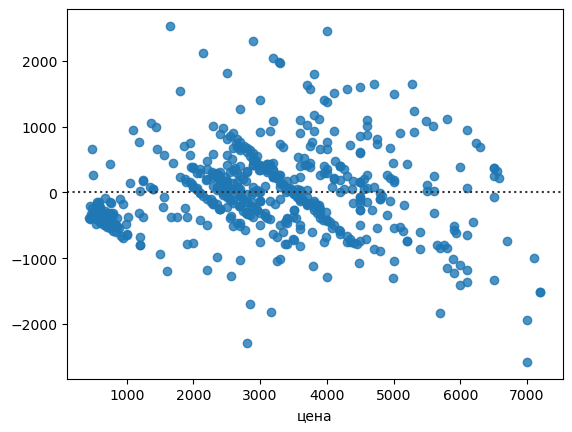

In [17]:
graph = sns.residplot(x=Y, y=preds)

Text(0.5, 9.444444444444438, 'residuals')

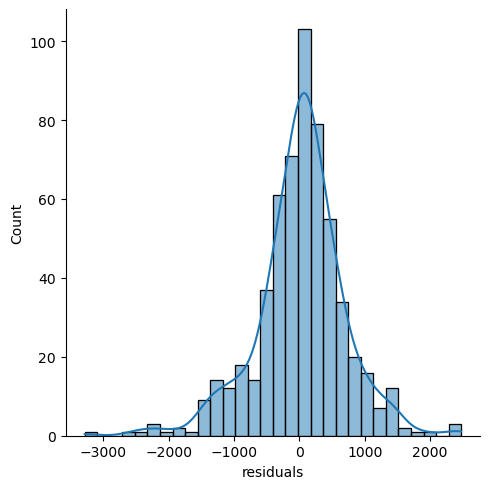

In [41]:
sns.displot(residuals, bins=30, kde=True)
plt.xlabel('residuals')

In [19]:
Y.iloc[:25]

0     2390.0
1      920.0
2     3250.0
3     3590.0
4     4500.0
5     2550.0
6     3000.0
7      800.0
8     4700.0
9     2970.0
10    4000.0
11    2450.0
12     570.0
13    4200.0
14    1190.0
15    2700.0
16    1999.0
17    3200.0
18    5500.0
19     649.0
20    4000.0
21    2350.0
22     590.0
23     700.0
24     990.0
Name: цена, dtype: float64

In [20]:
preds[:25]

array([2760.30769231,  609.14285714, 3425.        , 2947.5       ,
       5108.66666667, 3487.25      , 3399.17105263,  854.6       ,
       6066.66666667, 3399.17105263, 4499.21428571, 2541.70689655,
        609.14285714, 4011.47368421, 2254.82142857, 2541.70689655,
       1403.33333333, 3399.17105263, 5108.66666667,  672.5       ,
       3399.17105263, 2760.30769231,  854.6       ,  725.        ,
        854.6       ])

## Checking dummmy predictions
predict price based on flat_type

In [23]:
raise notImplementedErro()

Index(['Код объекта', 'трассы', 'автомобильные мосты', 'гостевой паркинг',
       'памятники архитектуры', 'культуры', 'пешеходные бульвары',
       'всего этажей', 'Общая площадь', 'Высота потолков', 'Комнатность',
       'подземный паркинг', 'Материал окон_Деревянные',
       'Материал окон_Пластиковые', 'Материал окон_Пластиковые/деревянные',
       'Счетчик воды_есть', 'Счетчик воды_отсутствует',
       'Балкон_Балкон и лоджия', 'Балкон_Два балкона и более',
       'Балкон_Есть балкон', 'Балкон_Лоджия', 'Балкон_Нет балкона',
       'Серия_1-335', 'Серия_1-335А', 'Серия_2-68-1-0', 'Серия_335-с',
       'Серия_75 ', 'Серия_75.1, 3-75', 'Серия_А-1', 'Серия_Бреж', 'Серия_Инд',
       'Серия_Общ', 'Серия_Хрущ', 'Стены_Блочные', 'Стены_Деревянные',
       'Стены_Кирпичные', 'Стены_Монолитные', 'Стены_Панельные',
       'Адрес_Голиковка', 'Адрес_Древлянка', 'Адрес_Зарека', 'Адрес_Ключевая',
       'Адрес_Кукковка', 'Адрес_Октябрьский', 'Адрес_Первомайский',
       'Адрес_Перевалка', 'Адре

In [21]:
means = X.join(Y).groupby('Серия')['цена'].mean()
means

KeyError: 'Серия'

In [ ]:
dummy_preds = X['Серия'].transform(lambda x: means[x]).values

In [ ]:
mean_squared_error(dummy_preds,Y)

In [ ]:
mean_absolute_error(dummy_preds,Y)

In [ ]:
graph = sns.residplot(x=dummy_preds, y=Y)


In [ ]:
residuals_dummy = dummy_preds - Y

In [ ]:
sns.displot(residuals_dummy, bins=30, kde=True)
plt.xlabel('residuals')

### models performs better then dummy regressor
I conclude that model works

## Save model parameters

In [ ]:
model.get_params()

In [ ]:
import pickle

In [ ]:
model.fit(X, Y)

In [103]:
#with open("model.pkl", "wb") as f:
#    pickle.dump(model, f)

In [104]:
#with open("model.pkl", "rb") as f:
#    derevo = pickle.load(f)